In [24]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import os
import zipfile
import tensorflow as tf

from keras import *
from keras.layers import Input, Conv2D, LeakyReLU, BatchNormalization, Concatenate, Conv2DTranspose, Dropout
from keras.models import Model
from keras.optimizers import *
from keras.losses import *

In [25]:
# import zipfile
# data_r = zipfile.ZipFile('..\\train.zip', 'r')
# data_r.extractall()

In [26]:
# data_r = zipfile.ZipFile('..\\test.zip', 'r')
# data_r.extractall()

In [27]:
def download_data(path):
  data = []
  for path_image in sorted(os.listdir(path=path)):
    image = Image.open(path + path_image) #Открываем изображение.
    data.append(np.array(image)) #Загружаем пиксели.
  return data

In [28]:
X_train = download_data(r"train/images/")
Y_train = download_data(r"train/masks/")
X_test = download_data(r"test/images/")
Y_test = download_data(r"test/masks/")

In [29]:
# задаём константы
IMG_WIDTH = 128                       # Ширина итогового изображения
IMG_LENGTH = 128                      # Длина итогового изображения
IMG_SHAPE  = (IMG_WIDTH, IMG_LENGTH)  # Формат изображения (ширина, длина)
CLASSES = 6 

In [30]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (IMG_WIDTH, IMG_LENGTH), method="nearest")
   input_mask = tf.image.resize(input_mask, (IMG_WIDTH, IMG_LENGTH), method="nearest")
   return input_image, input_mask

In [31]:
X_train, Y_train = resize(X_train, Y_train)
X_test, Y_test = resize(X_test, Y_test)

In [32]:
X_train

<tf.Tensor: shape=(7, 128, 128, 3), dtype=int32, numpy=
array([[[[238, 241, 246],
         [185, 190, 196],
         [249, 255, 255],
         ...,
         [178, 177, 185],
         [220, 219, 225],
         [235, 237, 250]],

        [[254, 255, 255],
         [252, 255, 255],
         [250, 251, 253],
         ...,
         [213, 209, 223],
         [199, 192, 199],
         [152, 145, 152]],

        [[194, 194, 196],
         [239, 238, 243],
         [253, 254, 255],
         ...,
         [ 96,  88, 101],
         [157, 142, 149],
         [148, 132, 133]],

        ...,

        [[213, 207, 217],
         [238, 233, 239],
         [211, 208, 219],
         ...,
         [247, 240, 234],
         [218, 211, 203],
         [241, 234, 224]],

        [[231, 225, 235],
         [166, 161, 167],
         [211, 208, 219],
         ...,
         [255, 253, 250],
         [237, 230, 222],
         [223, 216, 208]],

        [[246, 240, 250],
         [198, 191, 198],
         [199, 197

Объявление функций предобработки и пост обработки данных


In [33]:
# установка цвета полос
palette = {0 : (60, 16, 152), # Здания
           1 : (132, 41, 246), # Земля
           2 : (110, 193, 228), # Дороги
           3 : (254, 221, 58), # Растения
           4 : (226, 169, 41), # Вода
           5 : (155, 155, 155)} # Неразмечено

# обратное преобразование цвета в метку класса
invert_palette = {v: k for k, v in palette.items()}

# преобразование выхода нейронной сети в RGB изображение
def convert_to_color(arr_2d, palette=palette):
    """ Числовые метки для кодирования RGB-цвета """
    # zeros() возвращает новый массив указанной формы и типа, заполненный нулями.
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

In [34]:
def convert_from_color(arr_3d, palette=invert_palette):
    """ Кодирование цвета RGB в полутоновый маркер """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    # принадлежность каждого пикселя классу
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.int8)

    # расстояние до ближайшего класса для пикселей
    min_distance = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.float32)+1000 

    for c, i in palette.items():
      # ищем расстояние для каждого пикселя до проверяемого класса по евклиду рас-ие
      distance = np.sum((arr_3d - np.array(c).reshape(1, 1, 3))**2, axis=-1)**(1/2) 

      # поиск элементов меньше min_distance
      condition = min_distance > distance 

      # замена дистанции найденных элементов
      min_distance[condition] = distance[condition] 

      # замена класса найденных элементов
      arr_2d[condition] = i 

    for c, i in palette.items():
      m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
      arr_2d[m] = i

    arr_2d = arr_2d.tolist()
    for i in range(len(arr_2d)):
      for j in range(len(arr_2d[0])):
        label = [0, 0, 0, 0, 0, 0]
        label[arr_2d[i][j]] = 1
        arr_2d[i][j] = label
    arr_2d = np.array(arr_2d)

    return arr_2d

Предобработка исходных изображений и сегментированных изображений в ответ сети

In [35]:
# Следующий блок кода подготавливает данные для использования нейронной сетью
X_train_pred = np.array(X_train).reshape([7, IMG_WIDTH, IMG_LENGTH, 3])/255 
X_test_pred = np.array(X_test).reshape([2, IMG_WIDTH, IMG_LENGTH, 3])/255   
Y_train_pred = []
for i in range(len(Y_train)):
  Y_train_pred.append(convert_from_color(Y_train[i][:, :, :3]))
Y_train_pred = np.array(Y_train_pred)
Y_test_pred = []
for i in range(len(Y_test)):
  Y_test_pred.append(convert_from_color(Y_test[i][:, :, :3]))
Y_test_pred = np.array(Y_test_pred)

In [36]:
Y_train_pred

array([[[[0, 1, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0],
         ...,
         [0, 1, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0]],

        [[0, 1, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0],
         ...,
         [0, 1, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0]],

        [[0, 1, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0],
         ...,
         [0, 0, 0, 1, 0, 0],
         [0, 0, 0, 1, 0, 0],
         [0, 0, 0, 1, 0, 0]],

        ...,

        [[0, 1, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0],
         ...,
         [0, 1, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0]],

        [[0, 1, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0],
         ...,
         [0, 1, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0]],

        [[0, 1, 0, 0, 0, 0],
       

Объявление топологии нейронной сети

In [37]:
def unet_model(image_size, output_classes):

    #Входной слой
    input_layer = Input(shape=image_size + (3,))
    conv_1 = Conv2D(64, 4, activation=LeakyReLU(),
                                    strides=2, padding='same', kernel_initializer='glorot_normal',
                                    use_bias=False)(input_layer)
    #Сворачиваем
    conv_1_1 = Conv2D(128, 4, activation=LeakyReLU(), strides=2,
                                      padding='same', kernel_initializer='glorot_normal',
                                      use_bias=False)(conv_1)
    batch_norm_1 = BatchNormalization()(conv_1_1)

    #2
    conv_2 = Conv2D(256, 4, activation=LeakyReLU(), strides=2,
                                      padding='same', kernel_initializer='glorot_normal',
                                      use_bias=False)(batch_norm_1)
    batch_norm_2 = BatchNormalization()(conv_2)

    #3
    conv_3 = Conv2D(512, 4, activation=LeakyReLU(), strides=2,
                                      padding='same', kernel_initializer='glorot_normal',
                                      use_bias=False)(batch_norm_2)
    batch_norm_3 = BatchNormalization()(conv_3)

    #4
    conv_4 = Conv2D(512, 4, activation=LeakyReLU(), strides=2,
                                      padding='same', kernel_initializer='glorot_normal',
                                      use_bias=False)(batch_norm_3)
    batch_norm_4 = BatchNormalization()(conv_4)

    #5
    conv_5 = Conv2D(512, 4, activation=LeakyReLU(), strides=2,
                                      padding='same', kernel_initializer='glorot_normal',
                                      use_bias=False)(batch_norm_4)
    batch_norm_5 = BatchNormalization()(conv_5)

    #6
    conv_6 = Conv2D(512, 4, activation=LeakyReLU(), strides=2,
                                      padding='same', kernel_initializer='glorot_normal',
                                      use_bias=False)(batch_norm_5)


    #Разворачиваем
    #1
    up_1 = Concatenate()([Conv2DTranspose(512, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(conv_6), conv_5])
    batch_up_1 = BatchNormalization()(up_1)

    #Добавим Dropout от переобучения
    batch_up_1 = Dropout(0.25)(batch_up_1)

    #2
    up_2 = Concatenate()([Conv2DTranspose(512, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_1), conv_4])
    batch_up_2 = BatchNormalization()(up_2)
    batch_up_2 = Dropout(0.25)(batch_up_2)




    #3
    up_3 = Concatenate()([Conv2DTranspose(512, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_2), conv_3])
    batch_up_3 = BatchNormalization()(up_3)
    batch_up_3 = Dropout(0.25)(batch_up_3)




    #4
    up_4 = Concatenate()([Conv2DTranspose(256, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_3), conv_2])
    batch_up_4 = BatchNormalization()(up_4)


    #5
    up_5 = Concatenate()([Conv2DTranspose(128, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_4), conv_1_1])
    batch_up_5 = BatchNormalization()(up_5)


    #6
    up_6 = Concatenate()([Conv2DTranspose(64, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_5), conv_1])
    batch_up_6 = BatchNormalization()(up_6)


    #Выходной слой
    output_layer = Conv2DTranspose(output_classes, 4, activation='sigmoid', strides=2,
                                                   padding='same',
                                                   kernel_initializer='glorot_normal')(batch_up_6)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [38]:
model = unet_model(image_size=IMG_SHAPE, output_classes=CLASSES)

In [39]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │      3,072 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │    131,072 │ conv2d_7[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │    524,288 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 8, 8, 512) │  2,097,152 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 4, 4, 512) │  4,194,304 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 512) │      2,048 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 2, 2, 512) │  4,194,304 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 512) │      2,048 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 1, 1, 512) │  4,194,304 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_7  │ (None, 2, 2, 512) │  4,194,304 │ conv2d_13[0][0]   │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 2, 2,      │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 1024)             │            │ conv2d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2,      │      4,096 │ concatenate_6[0]… │
│ (BatchNormalizatio… │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 2, 2,      │          0 │ batch_normalizat… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_8  │ (None, 4, 4, 512) │  8,388,608 │ dropout_3[0][0]   │
│ (Conv2DTranspose)   │                   │            │                 

 Total params: 41,850,886 (159.65 MB)

 Trainable params: 41,839,110 (159.60 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [40]:
%%time
# Обучаем модель
history = model.fit(X_train_pred, Y_train_pred, batch_size=1, epochs=10, validation_data=(X_test_pred, Y_test_pred))

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.3662 - loss: 1.6600 - val_accuracy: 0.6123 - val_loss: 1.4697
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6530 - loss: 1.1703 - val_accuracy: 0.3956 - val_loss: 1.7214
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6867 - loss: 1.1397 - val_accuracy: 0.2928 - val_loss: 2.5211
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7171 - loss: 0.9786 - val_accuracy: 0.2835 - val_loss: 2.9479
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7047 - loss: 1.0272 - val_accuracy: 0.3261 - val_loss: 2.3846
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7669 - loss: 0.8851 - val_accuracy: 0.3955 - val_loss: 2.0571
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7689 - loss: 0.7422 - val_accuracy: 0.3759 - val_loss: 2.1663
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7788 - loss: 0.6788 - val_accuracy: 0.3996 - val_loss: 2.0165
Epoch 9/10
7/

### Отрисовка точности модели (при обучении и на тестовых данных)

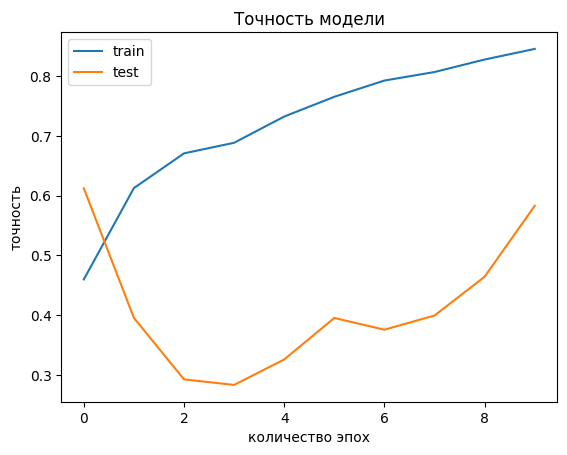

In [41]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Точность модели')
plt.ylabel('точность')
plt.xlabel('количество эпох')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [42]:
# Делаем сегментацию для двух тестовых картинок
out = model.predict(X_test_pred[:2], batch_size=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step


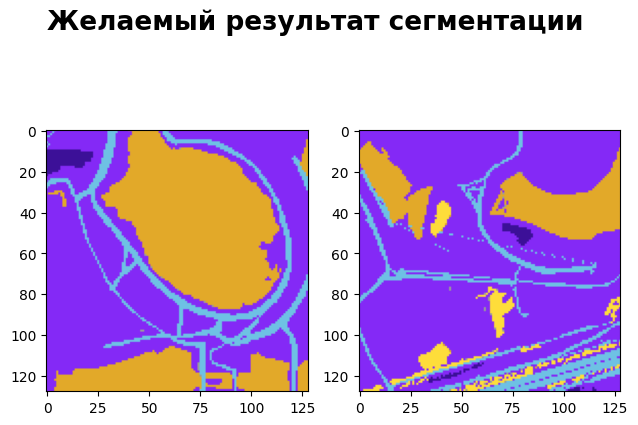

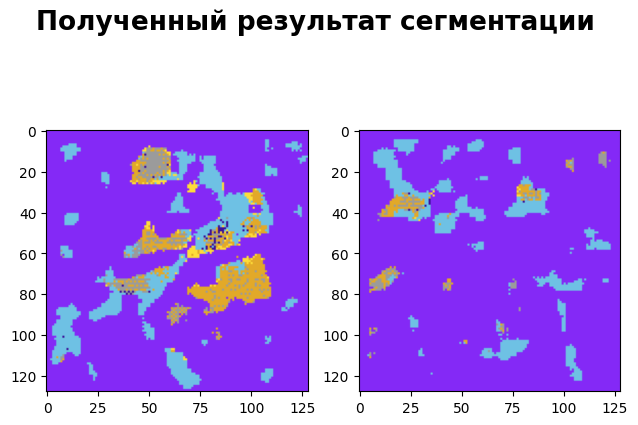

In [43]:
# Выведем 2-е тестовые картинки
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(convert_to_color(np.argmax(Y_test_pred[i], axis=-1)))
plt.suptitle('Желаемый результат сегментации', fontsize=19, fontweight='bold')
plt.tight_layout()
plt.show()

# Выведем 2-е картинки полученые методом predict
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(convert_to_color(np.argmax(out[i], axis=-1)))
plt.suptitle('Полученный результат сегментации', fontsize=19, fontweight='bold')
plt.tight_layout()
plt.show()

Вывод: В исследовании был использован пример с урока, дополненный моделью НС из гитхаба по котикам. После пары дней запуска, модель начала показывать что-то внятное: была проблема остановки accuracy на 60%. В данном исследовании точность модели на тестовых данных составила около 85%, при том на обучающих достигла 100% уже на 60 эпохе. Полученный результат сегментации похож на желаемый результат, но далек от идеала. Лучше всего модель выделила класс "Вода"